In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('bmh')


def process_model_name(model_full_name):
    model_type = ''
    if 'mono' in model_full_name:
        model_type = 'Baseline-Mono'
    elif 'multi' in model_full_name:
        model_type = 'Baseline-Multi'
    elif 'LoRa' in model_full_name:
        model_type = 'LoRa'
    elif 'Full' in model_full_name:
        model_type = 'Full'
    else:
        model_type = 'Unknown'
    pass_at = ''
    if 'pass_at_10' in model_full_name:
        pass_at = 'Pass@10'
    elif 'pass_at_100' in model_full_name:
        pass_at = 'Pass@100'

    human_eval_lang = model_full_name.split('_')[-6]
    # 'LoRa-V1-7000-pass@10'
    fine_tune_lang = 'None'
    ckpt_number = 0
    model_name = ''
    model_name_with_human_eval = ''
    if model_type == 'LoRa' or model_type == 'Full':
        fine_tune_lang = model_full_name.split('_')[1]
        fine_tune_lang = fine_tune_lang[0].upper() + fine_tune_lang[1:]
        ckpt_number = int(model_full_name.split('_')[7])
        model_name = f'{model_type}-{fine_tune_lang}-{ckpt_number}-{pass_at}'
        model_name_with_human_eval = f'{model_type}-{fine_tune_lang}-{ckpt_number}-{pass_at}-{human_eval_lang}'
    else:
        model_name = f'{model_type}-{pass_at}'
        model_name_with_human_eval = f'{model_type}-{pass_at}-{human_eval_lang}'
    info = {
        'model_type': model_type,
        'pass_at': pass_at,
        'human_eval_lang': human_eval_lang,
        'fine_tune_lang': fine_tune_lang,
        'ckpt_number': ckpt_number,
        'model_name': model_name,
        'model_name_with_human_eval': model_name_with_human_eval,
        'full_name': model_full_name,
    }
    return info

def get_results():
    results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]
    results = {}
    for f in results_files:
        with open(os.path.join('res', f)) as json_file:
            results[f] = json.load(json_file)
    return results

def get_df_from_results(results):
    dict_df = { 'model': [], 'dataset': [], 'pass@10': [], 'pass@100': [], 'num_problems': [], 'min_completions': [], 
    'max_completions': [], 'programming_language': [], 'fine-tune_language': [], 'model_type': [], 'ckpt_number': []}
    for model in results.keys():
        model_results = results[model]
        model_name = model.split('_results.json')[0]
        info = process_model_name(model_name)
        model_name = info['model_name']
        dataset_name = model_results['pass@10']['dataset']
        pass_10 = model_results['pass@10']['estimate']
        pass_100 = model_results['pass@100']['estimate']
        num_problems = model_results['pass@10']['num_problems']
        min_completions = model_results['pass@10']['min_completions']
        max_completions = model_results['pass@10']['max_completions']
        if 'humaneval_py' in dataset_name:
            programming_language = 'Python'
        elif 'humaneval_java' in dataset_name:
            programming_language = 'Java'
        elif 'humaneval_rs' in dataset_name:
            programming_language = 'Rust'
        elif 'humaneval_rb' in dataset_name:
            programming_language = 'Ruby'
        elif 'humaneval_swift' in dataset_name:
            programming_language = '"Swift'
        else:
            programming_language = 'unknown'
        dict_df['model'].append(model_name)
        dict_df['dataset'].append(dataset_name)
        dict_df['pass@10'].append(pass_10)
        dict_df['pass@100'].append(pass_100)
        dict_df['num_problems'].append(num_problems)
        dict_df['min_completions'].append(min_completions)
        dict_df['max_completions'].append(max_completions)
        dict_df['programming_language'].append(programming_language)
        dict_df['fine-tune_language'].append(info['fine_tune_lang'])
        dict_df['model_type'].append(info['model_type'])
        dict_df['ckpt_number'].append(info['ckpt_number'])
    df = pd.DataFrame(dict_df)
    df = df.drop(columns=['dataset'])
    df = df.drop(columns=['min_completions', 'max_completions'])
    df['pass@10'] = df['pass@10'] * 100
    df['pass@100'] = df['pass@100'] * 100
    df = df.rename(columns={'programming_language': 'Programming Language'})
    df = df.rename(columns={'model': 'Model'})
    df = df.rename(columns={'pass@10': 'Pass@10'})
    df = df.rename(columns={'pass@100': 'Pass@100'})
    df = df.sort_values(by=['Model'])
    return df





results = get_results()
df = get_df_from_results(results)

evaluation_languages = ['Python', 'Java', 'Rust', 'Ruby', 'Swift']
fine_tune_languages = ['Java', 'Ruby', 'Rust', 'Swift', 'Python']
programming_languages_color_map = {
    'Python': 'tab:blue',
    'Java': 'tab:orange',
    'Rust': 'tab:green',
    'Ruby': 'tab:red',
    'Swift': 'tab:purple',
}





# fig, ax = plt.subplots(figsize = (24, 8))
# for programming_language in programming_language_dirs:
#     df = dfs_dict[programming_language]
#     ax.plot(df["Step"], df["Loss"], label = programming_language.upper(), linewidth = 3)

# ax.set_xlabel("Step", fontsize = 24)
# ax.set_ylabel("Loss", fontsize = 24)
# ax.set_title("Eval Loss vs. Step for Different Programming Languages", fontsize = 24)
# ax.legend(fontsize = 24)
# ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

# #Add a grid
# ax.grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.1, axis='y', zorder = 0)
# ax.minorticks_on()
# ax.grid(which='minor', linestyle='-', linewidth='0.5', color='black', alpha=0.01, axis='y', zorder = 0)

# #Change background color
# ax.set_facecolor('#C7C7CF')
# fig.tight_layout()


fig, ax = plt.subplots(figsize=(24, 8))
for eval_lang in evaluation_languages:
    for tune_lang in fine_tune_languages:
        df_filtered = df[(df['Programming Language'] == eval_lang) & (df['fine-tune_language'] == tune_lang)]
        df_filtered = df_filtered.sort_values(by=['ckpt_number'])
        df_filtered = df_filtered.reset_index(drop=True)
        x = df_filtered['ckpt_number']
        y = df_filtered['Pass@10']
        color = programming_languages_color_map[tune_lang]
        if len(x) > 5:
            if eval_lang == tune_lang: # use solid line
                ax.plot(x, y, label=f'{tune_lang} Model', color= color, linestyle='solid', linewidth=3)
            else: # use dashed line and the color of the fine-tune language
                ax.plot(x, y, label=f'{tune_lang} Model on {eval_lang}', color=color, linestyle='dashed', linewidth=3)
ax.set_xlabel('Checkpoint Number', fontsize=24)
ax.set_ylabel('Pass@10', fontsize=24)
ax.set_title('Pass@10 vs Checkpoint Number', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.legend(fontsize=12)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.1, axis='y', zorder=0)
ax.minorticks_on()
ax.grid(which='minor', linestyle='-', linewidth='0.5', color='black', alpha=0.01, axis='y', zorder=0)
ax.set_facecolor('#C7C7CF')
fig.tight_layout()


fig_save_path = "figures/pass_at_10_all.pdf"
if not os.path.exists(os.path.dirname(fig_save_path)):
    os.makedirs(os.path.dirname(fig_save_path))
fig.savefig(fig_save_path, bbox_inches = "tight")


plt.show()




In [ ]:
df

In [ ]:
results = get_results()
df = get_df_from_results(results)


fine_tune_language = 'Ruby'
#Filter data frame by the fine tune language
df = df[df['fine-tune_language'] == fine_tune_language]
#Sort the data frame by the  ckpt_number
df = df.sort_values(by=['ckpt_number'])




#Set the pass type to plot
pass_type = 'Pass@10'


#Plot the results
#Set the style
sns.set_theme(style="whitegrid")
#Set the plot size
sns.set(rc={'figure.figsize':(15.7,4.27)})
ax = sns.barplot(x="Model", y=pass_type, hue="Programming Language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#set the y axis to start at 0 and end at 50
plt.ylim(0, 50)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#Add a title in bigger font
plt.title(f'{pass_type} for the different models', fontsize=20)
plt.show()



In [ ]:
df

In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

#get all the results files in the res folder
results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]

#load all the results files into a dictionary
results = {}
for f in results_files:
    with open(os.path.join('res', f)) as json_file:
        results[f] = json.load(json_file)
model_names_dict = {
    
    'codegen_350M_mono_humaneval_py_pass_at_10_gen_config': 'Baseline-mono',
    'codegen_350M_mono_humaneval_java_pass_at_10_gen_config': 'Baseline-mono',
    'codegen_350M_mono_humaneval_rb_pass_at_10_gen_config': 'Baseline-mono',
    'codegen_350M_mono_humaneval_rs_pass_at_10_gen_config': 'Baseline-mono',
    'codegen_350M_mono_humaneval_swift_pass_at_10_gen_config': 'Baseline-mono',
    
    

    'codegen_350M_multi_humaneval_py_pass_at_10_gen_config': 'Baseline-multi',
    'codegen_350M_multi_humaneval_java_pass_at_10_gen_config': 'Baseline-multi',
    'codegen_350M_multi_humaneval_rb_pass_at_10_gen_config': 'Baseline-multi',
    'codegen_350M_multi_humaneval_rs_pass_at_10_gen_config': 'Baseline-multi',
    'codegen_350M_multi_humaneval_swift_pass_at_10_gen_config': 'Baseline-multi',
    

    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'LoRa-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'LoRa-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'LoRa-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'LoRa-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'LoRa-Java',

    
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'LoRa-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'LoRa-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'LoRa-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'LoRa-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'LoRa-Ruby',


    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'LoRa-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'LoRa-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'LoRa-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'LoRa-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'LoRa-Rust',


    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'LoRa-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'LoRa-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'LoRa-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'LoRa-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'LoRa-Swift',
    
}


#Merge all the results into a single dataframe
dict_df = { 'model': [], 'dataset': [], 'pass@10': [], 'pass@100': [], 'num_problems': [], 'min_completions': [], 'max_completions': [], 'programming_language': []}

for model in results.keys():
    model_results = results[model]
    model_name = model.split('_results.json')[0]
    if model_name in model_names_dict.keys():
        model_name = model_names_dict[model_name]
    else:
        print('Model name not found in dict: ' + model_name)
        continue
    dataset_name = model_results['pass@10']['dataset']
    pass_10 = model_results['pass@10']['estimate']
    pass_100 = model_results['pass@100']['estimate']
    num_problems = model_results['pass@10']['num_problems']
    min_completions = model_results['pass@10']['min_completions']
    max_completions = model_results['pass@10']['max_completions']
    if 'humaneval_py' in dataset_name:
        programming_language = 'python'
    elif 'humaneval_java' in dataset_name:
        programming_language = 'java'
    elif 'humaneval_rs' in dataset_name:
        programming_language = 'rust'
    elif 'humaneval_rb' in dataset_name:
        programming_language = 'ruby'
    elif 'humaneval_swift' in dataset_name:
        programming_language = 'swift'
    else:
        programming_language = 'unknown'
    dict_df['model'].append(model_name)
    dict_df['dataset'].append(dataset_name)
    dict_df['pass@10'].append(pass_10)
    dict_df['pass@100'].append(pass_100)
    dict_df['num_problems'].append(num_problems)
    dict_df['min_completions'].append(min_completions)
    dict_df['max_completions'].append(max_completions)
    dict_df['programming_language'].append(programming_language)

df = pd.DataFrame(dict_df)
df = df.drop(columns=['dataset'])
df = df.drop(columns=['min_completions', 'max_completions'])
df = df[df['model'] != 'LoRa-V3-2000']
df = df[df['model'] != 'LoRa-V5-1000']
df['pass@10'] = df['pass@10'] * 100
df['pass@100'] = df['pass@100'] * 100

df = df.rename(columns={'programming_language': 'Programming Language'})
df = df.rename(columns={'model': 'Model'})
df = df.rename(columns={'pass@10': 'Pass@10'})
df = df.rename(columns={'pass@100': 'Pass@100'})

df['Programming Language'] = df['Programming Language'].replace({'java': 'Java', 'python': 'Python'})

#Sort the dataframe by the model name
df = df.sort_values(by=['Model'])

#Set the pass type to plot
pass_type = 'Pass@10'


#Plot the results
#Set the style
sns.set_theme(style="whitegrid")
#Set the plot size

#drop Pass@100 column 
df = df.drop(columns=['Pass@100'])


Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_2000_humaneval_java_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_2000_humaneval_py_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_3000_humaneval_java_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_3000_humaneval_py_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_5000_humaneval_java_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_5000_humaneval_py_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_6000_humaneval_java_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_6000_humaneval_py_pass_at_10_gen_config
Model name not found in dict: codegen_java_LoRa_v7_run_1_checkpoint_7000_humaneval_java_pass_at_10_gen_config
Model name not fou

In [11]:
df

,Model,Pass@10,num_problems,Programming Language
0,Baseline-mono,1.898734,158,Java
1,Baseline-mono,22.360248,161,Python
2,Baseline-mono,1.282051,156,rust
3,Baseline-multi,7.594937,158,Java
4,Baseline-multi,12.422360,161,Python
5,Baseline-multi,0.000000,161,ruby
6,Baseline-multi,0.641026,156,rust
7,Baseline-multi,0.621118,161,swift
12,LoRa-Java,0.621118,161,swift
10,LoRa-Java,0.000000,161,ruby


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

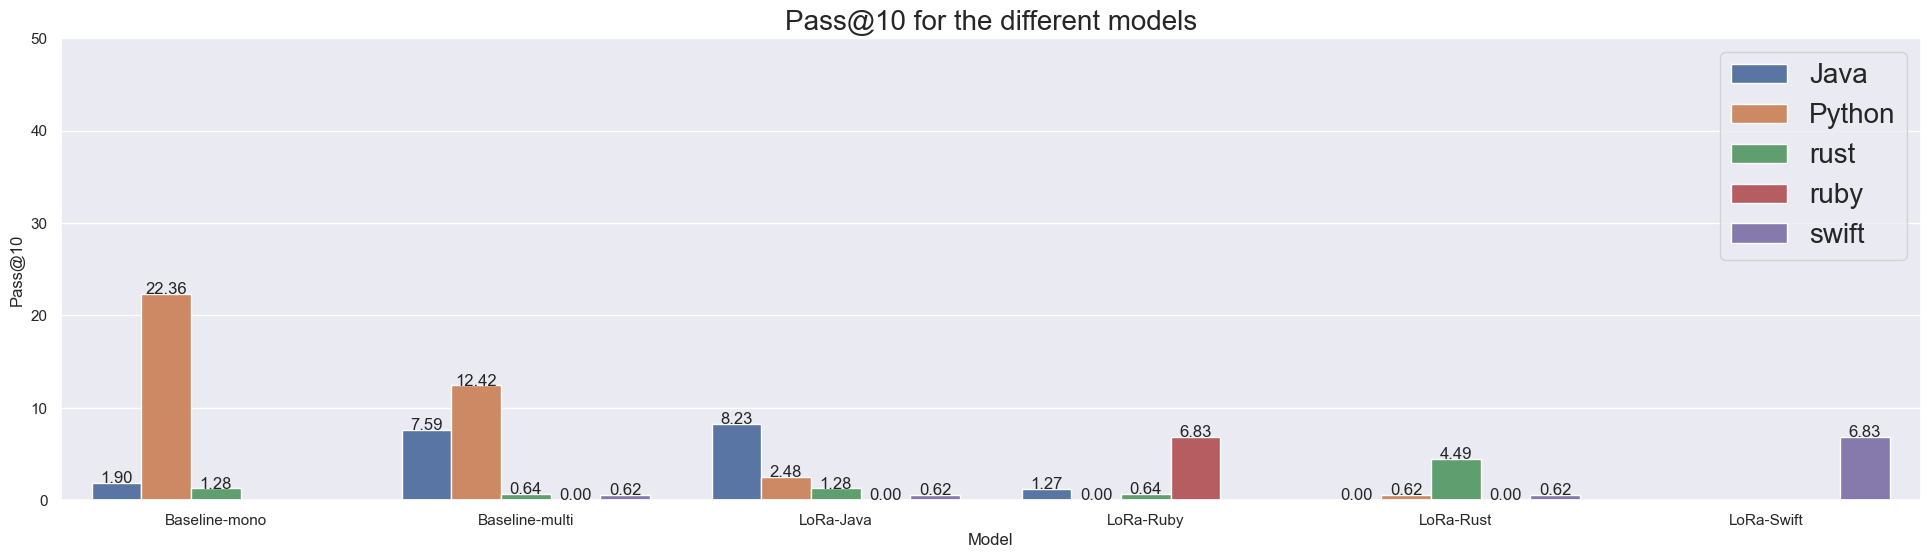

In [15]:
sns.set(rc={'figure.figsize':(24, 6)})
ax = sns.barplot(x="Model", y=pass_type, hue="Programming Language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 50
plt.ylim(0, 50)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#Add a title in bigger font
plt.title(f'{pass_type} for the different models', fontsize=20)

#place the legend on the top right corner
plt.legend(loc='upper right', fontsize=20)



fig_name = f'all_models_{pass_type}.pdf'
plt.savefig(fig_name, bbox_inches='tight')


plt.show()

In [7]:
df

,Model,Pass@10,Pass@100,num_problems,Programming Language
0,Baseline-mono,1.898734,100.0,158,Java
1,Baseline-mono,22.360248,100.0,161,Python
2,Baseline-mono,1.282051,100.0,156,rust
3,Baseline-multi,7.594937,100.0,158,Java
4,Baseline-multi,12.422360,100.0,161,Python
5,Baseline-multi,0.000000,100.0,161,ruby
6,Baseline-multi,0.641026,100.0,156,rust
7,Baseline-multi,0.621118,100.0,161,swift
12,LoRa-Java,0.621118,100.0,161,swift
11,LoRa-Java,1.282051,100.0,156,rust
